In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/e-commerce-transactions-dataset/ecommerce_transactions.csv


## Introduction

It is crucial to understand and predict customer spending behavior in the e-commerce industry in order optimize pricing strategies, improve inventory management, and personalize marketing efforts. However, with diverse user demographics, product categories, and payment preferences, it is challenging to accurately estimate how much a customer will spend on a given transaction. In this project, we will attempt to predict the Purchase_Amount of e-commerce transactions based on available features in an effort to enable businesses to forecast revenue, identify high-value customers, and detect anomalies in spending patterns.

**Tools**

We will use the following tools and libraries in Python to build this solution:

- **Pandas and NumPy:** For data manipulation and numerical operations.
- **Matplotlib and Seaborn:** For data visualization during exploratory data analysis (EDA).
- **Scikit-learn:** For preprocessing, model training, and evaluation.
- **XGBoost:** For advanced modeling if needed.
- **Jupyter Notebook:** To document the workflow (or a similar environment you’re using).

**Objectives**

By the end of this project, we hope to:

1. **Predict Purchase Amount:** Build a regression model to estimate the Purchase_Amount for a given transaction using features like Age, Country, Product_Category, Payment_Method, and Transaction_Date.
2. **Understand Consumer Behavior:** Identify key factors influencing spending, such as age groups or product categories, to provide actionable insights.
3. **Augment ML Skills:** Practice and demonstrate an understanding of the machine learning pipeline—data preprocessing, EDA, modeling, and evaluation.

## 1. Importing Libraries

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading and Cleaning

In this section, we will load the dataset and make sure it is sutiable for to explore basic visualization. We will do this by making sure there are no null or duplicated values. We will additionally make sure our columns are of the correct dtypes, and drop redudant columns if necessary. 

In [53]:
# load the dataset and view first 5 instances
df = pd.read_csv('/kaggle/input/e-commerce-transactions-dataset/ecommerce_transactions.csv')
df.head()

,Transaction_ID,User_Name,Age,Country,Product_Category,Purchase_Amount,Payment_Method,Transaction_Date
0,1,Ava Hall,63,Mexico,Clothing,780.69,Debit Card,2023-04-14
1,2,Sophia Hall,59,India,Beauty,738.56,PayPal,2023-07-30
2,3,Elijah Thompson,26,France,Books,178.34,Credit Card,2023-09-17
3,4,Elijah White,43,Mexico,Sports,401.09,UPI,2023-06-21
4,5,Ava Harris,48,Germany,Beauty,594.83,Net Banking,2024-10-29


In [54]:
# view dataset basic info such as columns, their dtypes etc
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction_ID    50000 non-null  int64  
 1   User_Name         50000 non-null  object 
 2   Age               50000 non-null  int64  
 3   Country           50000 non-null  object 
 4   Product_Category  50000 non-null  object 
 5   Purchase_Amount   50000 non-null  float64
 6   Payment_Method    50000 non-null  object 
 7   Transaction_Date  50000 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.1+ MB


In [55]:
# check for null values
df.isnull().sum()

Transaction_ID      0
User_Name           0
Age                 0
Country             0
Product_Category    0
Purchase_Amount     0
Payment_Method      0
Transaction_Date    0
dtype: int64

In [56]:
# check for duplicates
df.duplicated().sum()

0

In [57]:
# view summary statistics
df.describe()

,Transaction_ID,Age,Purchase_Amount
count,50000.000000,50000.000000,50000.000000
mean,25000.500000,43.968680,503.159793
std,14433.901067,15.260578,286.563558
min,1.000000,18.000000,5.040000
25%,12500.750000,31.000000,255.450000
50%,25000.500000,44.000000,503.110000
75%,37500.250000,57.000000,751.162500
max,50000.000000,70.000000,999.980000


#### **Notes:**

Here are some key insights so far:
- **Transaction_ID**: An integer identifier (not a feature for modeling, just an index).
- **User_Name**: An object (string), likely irrelevant for prediction unless it encodes something meaningful, so we’ll exclude it from modeling.
- **Age**: An integer ranging from 18 to 70, with a mean of ~44—good for numerical analysis.
- **Country, Product_Category, Payment_Method**: Categorical (object) columns, which we’ll explore with count plots.
- **Purchase_Amount**: A float ranging from $5 to ~$1000, with a mean of ~$503—our target variable.
- **Transaction_Date**: An object (likely a string), which we’ll need to convert to a datetime format for analysis.

**Things to do:**

1. Parse Transaction_Date as a datetime object (this can be done while loading the dataset by using the parse_dates parameter inside the .read_csv() method).
2. Drop User_Name from the analysis since it’s irrelevant for prediction.

In [58]:
# Parse Transaction_Date as a datetime object
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])

# Drop User_Name
df = df.drop(columns=['User_Name'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction_ID    50000 non-null  int64         
 1   Age               50000 non-null  int64         
 2   Country           50000 non-null  object        
 3   Product_Category  50000 non-null  object        
 4   Purchase_Amount   50000 non-null  float64       
 5   Payment_Method    50000 non-null  object        
 6   Transaction_Date  50000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 2.7+ MB


## 3. EDA

Exploratory Data Analysis (EDA) is the foundation of any machine learning project. It helps us understand the structure of the dataset as well as to uncover patterns, detect anomalies, and identify potential challenges (e.g., skewed distributions). For this e-commerce dataset, this process will reveal trends in spending behavior, relationships between features and Purchase_Amount, and help inform preprocessing decisions that will be undertaken before building a model. In order to achieve this, we will have to:

- Visualize distributions of numerical features (Age, Purchase_Amount).
- Explore categorical features (Country, Product_Category, Payment_Method) with count plots.
- Analyze trends over time using Transaction_Date.
- Investigate relationships (e.g., Purchase_Amount vs. Age or Product_Category).

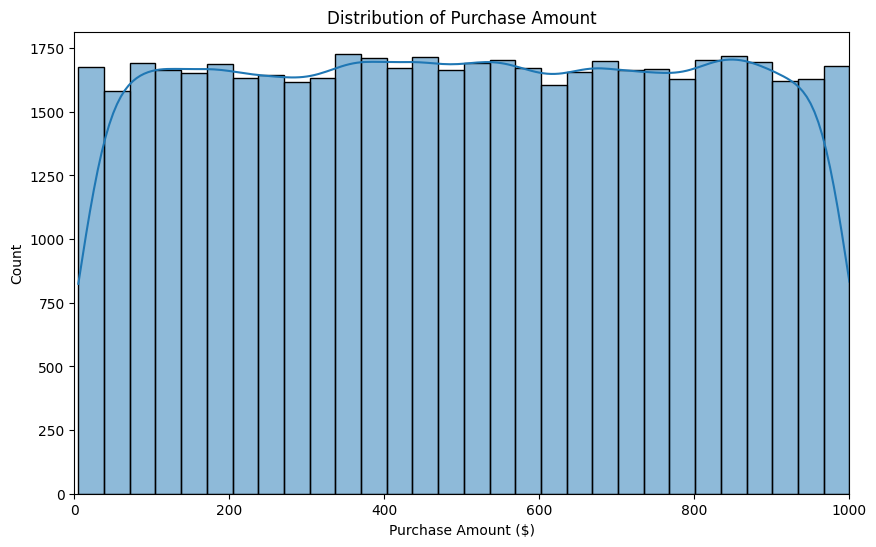

In [59]:
# Distribution of purchase amount
plt.figure(figsize=(10, 6))
sns.histplot(df['Purchase_Amount'], bins=30, kde=True)
plt.title('Distribution of Purchase Amount')
plt.xlabel('Purchase Amount ($)')
plt.xlim(0, 1000) # based on the range of the Purchase_Amount
plt.show()

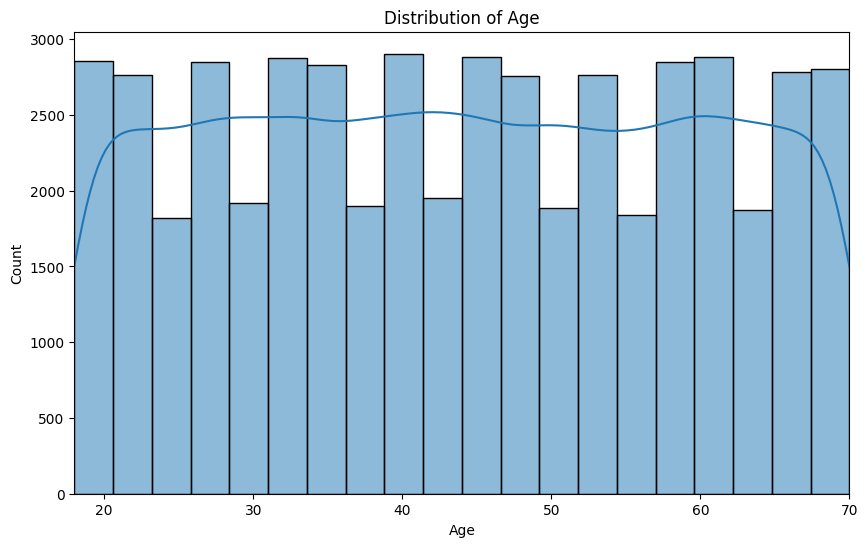

In [60]:
# Distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.xlim(18, 70) # based on the range of the Age column
plt.show()

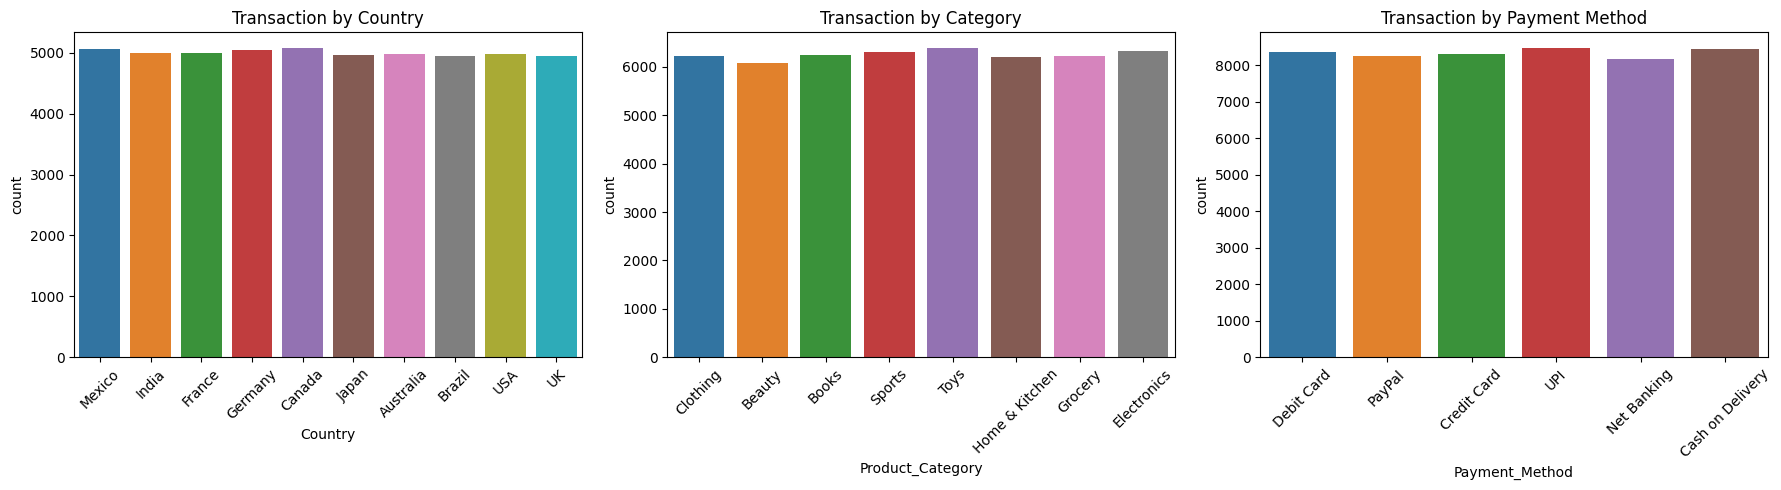

In [61]:
# count plots for categorical values
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(data=df, x='Country', ax=axes[0])
axes[0].set_title('Transaction by Country')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(data=df, x='Product_Category', ax=axes[1])
axes[1].set_title('Transaction by Category')
axes[1].tick_params(axis='x', rotation=45)

sns.countplot(data=df, x='Payment_Method', ax=axes[2])
axes[2].set_title('Transaction by Payment Method')
axes[2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

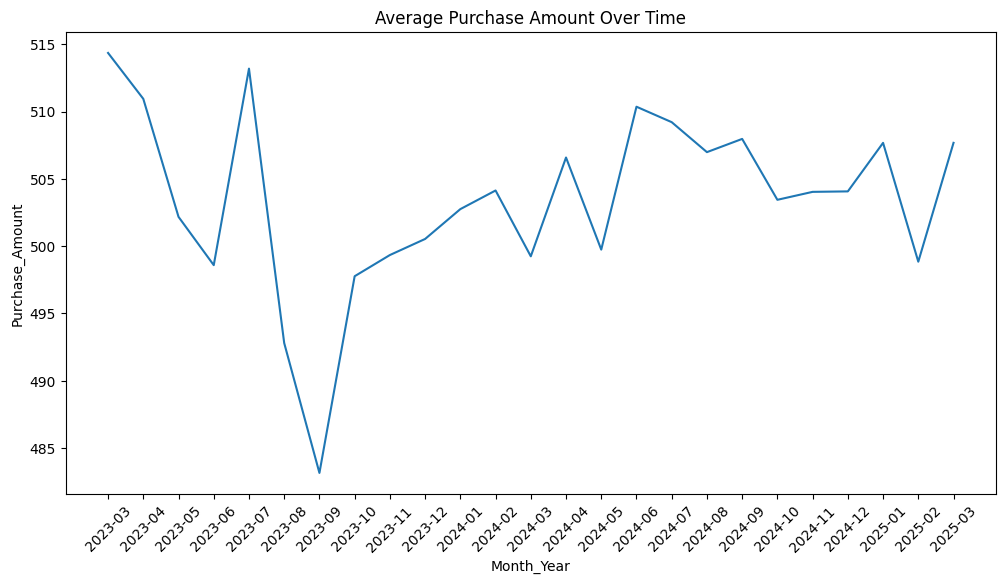

In [62]:
# Purchase_Amount over time (monthly trend) 
df['Month_Year'] = df['Transaction_Date'].dt.to_period('M').astype(str)  # Convert Period to string
monthly_trends = df.groupby('Month_Year')['Purchase_Amount'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trends, x='Month_Year', y='Purchase_Amount')
plt.title('Average Purchase Amount Over Time')
plt.xticks(rotation=45)
plt.show()

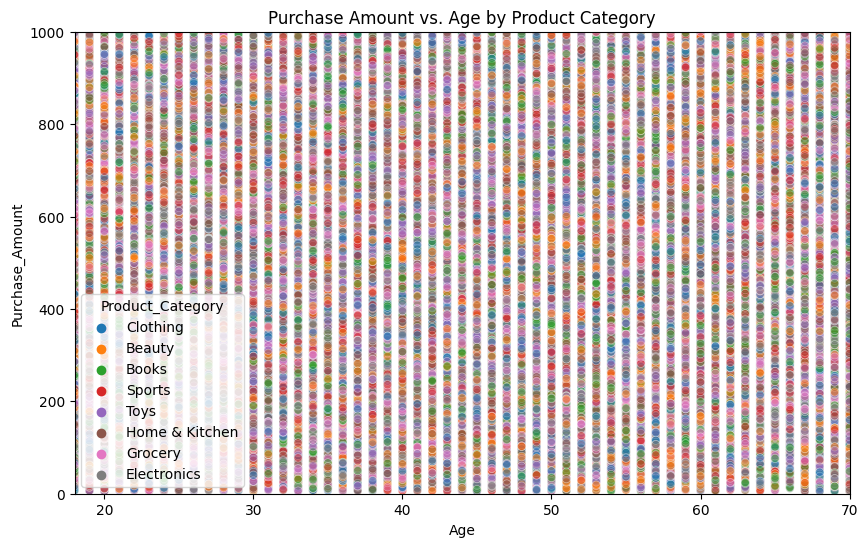

In [63]:
# Purchase_Amount vs. Age (scatter plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='Purchase_Amount', hue='Product_Category', alpha=0.5)
plt.title('Purchase Amount vs. Age by Product Category')
plt.xlim(18, 70)
plt.ylim(0, 1000)
plt.show()

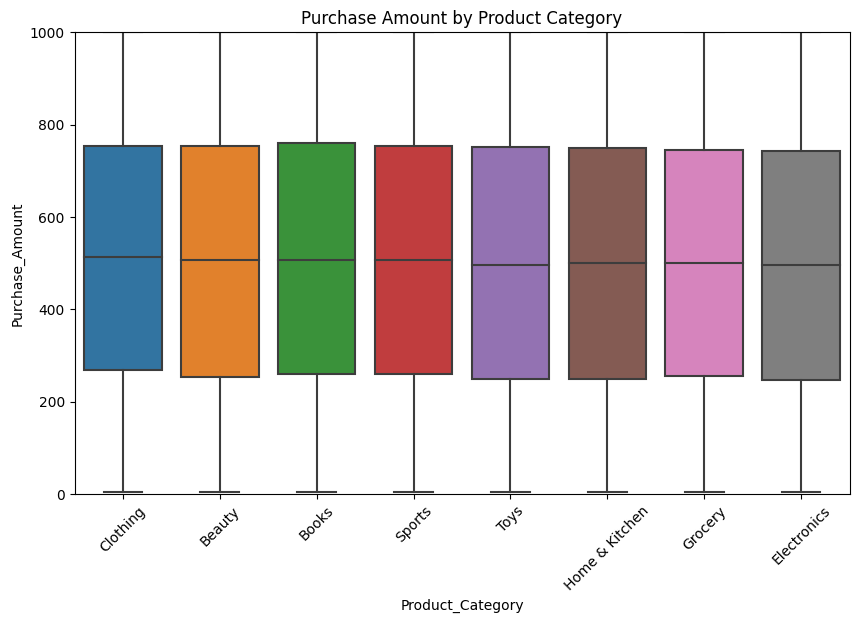

In [64]:
# Purchase_Amount by Product_Category (box plot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Product_Category', y='Purchase_Amount')
plt.title('Purchase Amount by Product Category')
plt.xticks(rotation=45)
plt.ylim(0, 1000)
plt.show()

#### **Notes on EDA**

We all new from the beginning that this was a synthetic dataset, but since this is project is purely for learning, let's do an analysis. The plots from EDA confirm the synthetic nature of the dataset in the following manner:

- **Distribution of Purchase_Amount:**
  - The histogram shows a uniform distribution with all values having counts between 1600 and 1700, exhibiting an almost calculated increase and decrease. This lack of skewness or natural variation (e.g., no heavy tails or clustering around certain price points) is a strong indicator of synthetic generation, where values are evenly distributed between $5 and $1000 (as confirmed by df.describe(): min=5.04, max=999.98, mean=503.16).
    
- **Distribution of Age:**
    - Similarly, the Age distribution mirrors this uniformity, with all age groups (18 to 70) having comparable counts. In a real-world dataset, we might expect peaks at certain age ranges (e.g., younger adults or middle-aged shoppers), but the even spread here further supports the synthetic design.

- **Categorical Features (Country, Product_Category, Payment_Method):**
    - The count plots for Country, Product_Category, and Payment_Method show very similar counts across all categories. In a natural dataset, we’d typically see some categories dominating (e.g., higher transaction counts for "Electronics" or "Credit Card"), but the balanced distribution here suggests intentional randomization rather than organic consumer behavior.
Box Plots (Purchase_Amount by Product_Category):
The box plots display no outliers and maintain the same uniform distribution across categories, with medians, quartiles, and ranges appearing nearly identical. Real-world data would likely show variability (e.g., "Electronics" having a higher median purchase amount than "Books"), but this consistency aligns with synthetic generation.

- **Average Purchase Amount Over Time:**

    - The time series plot stands out as the only visualization not showing overt signs of engineering. Unlike the other features, the average Purchase_Amount over time (grouped by month) likely exhibits some fluctuations, as the synthetic dataset’s Transaction_Date values (randomly selected over two years) introduce variability when aggregated. This plot may reveal subtle trends or noise, offering a glimpse of potential patterns we can leverage later.

## 4. Feature Engineering

Feature engineering transforms raw data into meaningful inputs for machine learning models thereby improving their accuracy and interpretability. For this e-commerce dataset where natural patterns are minimal, feature engineering is critical to create new variables that capture potential relationships. Such relationships include temporal trends, customer demographics and so forth. These new features imporove the performance of our model by making the uniform data more expressive.

**What we will do:**

- Drop Transaction_ID (we should have done this earlier, I am just now realizing that)
- Convert Transaction_Date into useful components (e.g., year, month, day of week) to capture temporal patterns.
- Bin Age into groups (e.g., young adults, middle-aged, seniors) to test if broader categories reveal spending trends.
- Encode categorical variables (Country, Product_Category, Payment_Method) using one-hot encoding for model compatibility.
- Explore interaction terms or derived features (e.g., Purchase_Amount per Age group) if initial modeling suggests weak signals.

In [65]:
# Drop Transaction_ID
df = df.drop(columns=['Transaction_ID'])

In [66]:
# Extract features from Transaction_Date
df['Year'] = df['Transaction_Date'].dt.year
df['Month'] = df['Transaction_Date'].dt.month
df['Day_of_Week'] = df['Transaction_Date'].dt.dayofweek  # 0 = Monday, 6 = Sunday

In [67]:
# Bin Age into categories
age_bins = [18, 30, 45, 60, 70]
age_labels = ['18-30', '31-45', '46-60', '61-70']
df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, include_lowest=True)

In [68]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Country', 'Product_Category', 'Payment_Method'], drop_first=True)

In [69]:
# Check the resulting dataset
print("Feature Engineered Dataset Shape:", df_encoded.shape)
print("\nFirst 5 Rows:")
print(df_encoded.head())
print("\nData Types:")
print(df_encoded.dtypes)

Feature Engineered Dataset Shape: (50000, 29)

First 5 Rows:
   Age  Purchase_Amount Transaction_Date Month_Year  Year  Month  Day_of_Week  \
0   63           780.69       2023-04-14    2023-04  2023      4            4   
1   59           738.56       2023-07-30    2023-07  2023      7            6   
2   26           178.34       2023-09-17    2023-09  2023      9            6   
3   43           401.09       2023-06-21    2023-06  2023      6            2   
4   48           594.83       2024-10-29    2024-10  2024     10            1   

  Age_Group  Country_Brazil  Country_Canada  ...  \
0     61-70           False           False  ...   
1     46-60           False           False  ...   
2     18-30           False           False  ...   
3     31-45           False           False  ...   
4     46-60           False           False  ...   

   Product_Category_Electronics  Product_Category_Grocery  \
0                         False                     False   
1                

#### Analysis of Results

The feature engineering process has transformed out dataset in the following ways:

1. **Shape**
   - The increase from 8 to 29 columns reflects the addition of new features and the one-hot encoding of categorical variables. This expansion is expected given:
        - 3 new temporal features (Year, Month, Day_of_Week).
        - 1 new binned feature (Age_Group).
        - One-hot encoding of Country (10 countries → 9 dummy columns after dropping the first).
        - One-hot encoding of Product_Category (e.g., 6 categories like Electronics, Clothing, etc. → 5 dummy columns).
        - One-hot encoding of Payment_Method (e.g., 5 methods like Credit Card, PayPal, etc. → 4 dummy columns).
    - The total aligns with dropping User_Name and Transaction_ID, adding 4 new features, and encoding 3 categorical variables.
2. **Sample Rows**
    - Numerical Features: Age (e.g., 63, 59, 26) and Purchase_Amount (e.g., 780.69, 738.56, 178.34) remain unchanged, providing the raw data for prediction.
    - Temporal Features:
        - Year (2023, 2024) and Month (e.g., 4, 7, 9, 10) capture the transaction timing over the past two years.
        - Day_of_Week (e.g., 4=Friday, 6=Sunday, 2=Wednesday, 1=Tuesday) indicates the day of purchase, which could reveal weekly spending patterns.
    - Binned Feature: Age_Group (e.g., 61-70, 46-60, 18-30, 31-45) groups ages into meaningful categories, potentially simplifying age-related trends.
    - One-Hot Encoded Features: Boolean columns (e.g., Country_Brazil, Product_Category_Electronics, Payment_Method_Credit Card) show the presence (True) or absence (False) of each category, making the data suitable for machine learning models.

## 5. Model Training and Evaluation

Steps:
1. Split the data into training and testing sets (e.g., 80/20).
2. Scale numerical features (Age, Year, Month, Day_of_Week) using StandardScaler within a pipeline, leaving binary one-hot features unscaled.
3. Train multiple regression models: Linear Regression (baseline), Random Forest Regressor (robust ensemble), and XGBoost Regressor (high-performance boosting).
4. Evaluate models using metrics like Mean Squared Error (MSE) and R² Score to assess prediction accuracy and fit.
5. Visualize predicted vs. actual values to interpret performance.

In [70]:
# Explicitly drop non-feature columns
df_encoded = df_encoded.drop(columns=['Transaction_Date', 'Month_Year'])

In [71]:
# Define features (X) and target (y)
X = df_encoded.drop(columns=['Purchase_Amount'])
y = df_encoded['Purchase_Amount']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# Define columns for preprocessing
numerical_cols = ['Age', 'Year', 'Month', 'Day_of_Week']
categorical_cols = ['Age_Group']
binary_cols = [col for col in X.columns if col not in numerical_cols + categorical_cols]  # All bool columns

In [73]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),           # Scale numerical features
        ('cat', OneHotEncoder(drop='first'), categorical_cols),  # Encode Age_Group
        ('binary', 'passthrough', binary_cols)              # Pass through binary features
    ]
)

In [74]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

Linear Regression - MSE: 82942.88, R²: -0.00


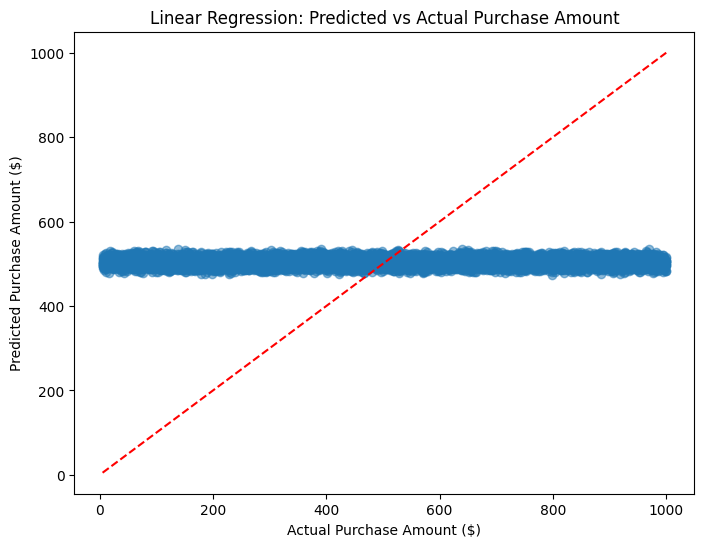

Random Forest - MSE: 89548.33, R²: -0.08


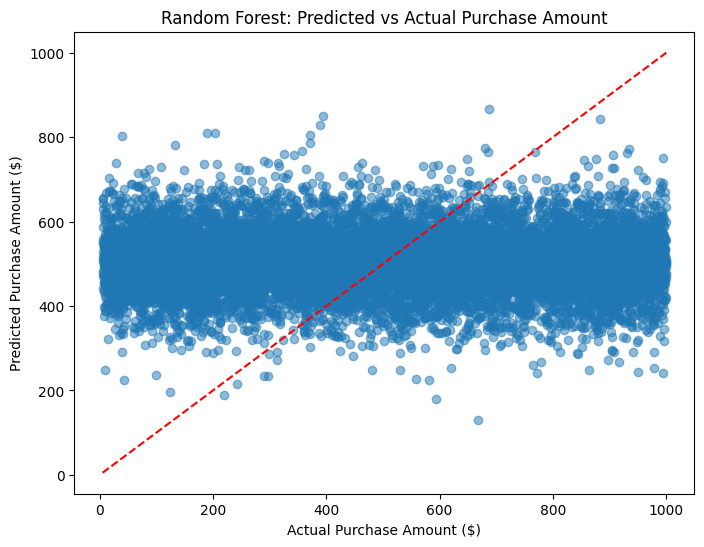

XGBoost - MSE: 88179.52, R²: -0.07


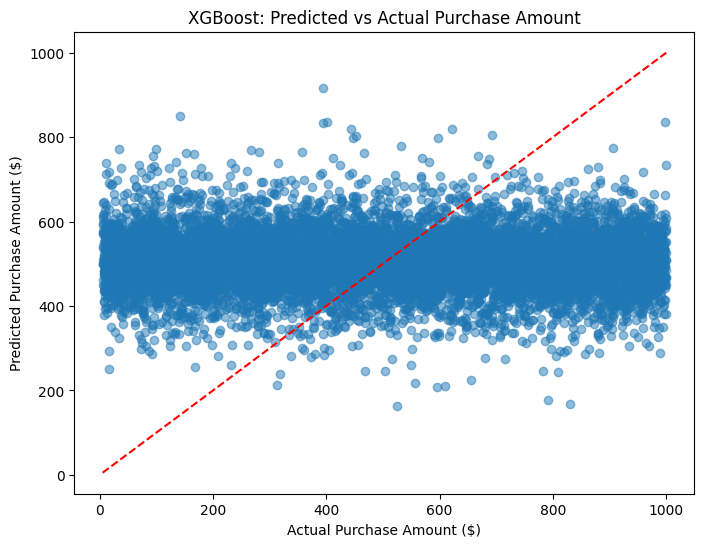

In [75]:
# Train and evaluate models
results = {}
for name, model in models.items():
    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = pipeline.predict(X_test)
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2}
    print(f"{name} - MSE: {mse:.2f}, R²: {r2:.2f}")

    # Plot predicted vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'{name}: Predicted vs Actual Purchase Amount')
    plt.xlabel('Actual Purchase Amount ($)')
    plt.ylabel('Predicted Purchase Amount ($)')
    plt.show()

#### **Analysis of Results**

The performance metrics for the three regression models—Linear Regression, Random Forest, and XGBoost—reveal the following:

1. **Linear Regression:**
    - MSE: 82,942.88
    - R²: -0.00
    - **Interpretation:** The Mean Squared Error (MSE) is quite high, indicating significant prediction error. An R² score of -0.00 (essentially 0) means the model explains none of the variance in Purchase_Amount and performs no better than a simple mean prediction. This suggests that the relationship between the features and the target is not linear, or the features lack sufficient predictive power.
2. **Random Forest**
    - MSE: 89,548.33
    - R²: -0.08
    - **Interpretation:** The MSE is higher than Linear Regression, and the negative R² score (-0.08) indicates the model performs worse than a mean baseline. Random Forest, despite its ability to capture non-linear relationships, fails to find meaningful patterns, likely due to the synthetic dataset’s uniformity noted in EDA.
3. **XGBoost**
    - MSE: 88,179.52
    - R²: -0.07
    - **Interpretation:** Similar to Random Forest, XGBoost has a high MSE and a negative R² (-0.07), performing slightly worse than the mean baseline. Even with its advanced boosting capabilities, it struggles to improve over simpler models, reinforcing the challenge posed by the dataset.
4. **General Observations**
    - **High MSE:** All models produce MSE values in the range of 82,000–90,000, which is substantial given Purchase_Amount ranges from $5 to $1000 (mean ~$503). This suggests predictions are off by hundreds of dollars on average.
    - **Negative/Near-Zero R²:** All R² scores are effectively zero or negative, indicating none of the models capture the variance in Purchase_Amount. In a synthetic dataset with uniform distributions (as seen in EDA), the lack of natural patterns likely explains this poor performance.
    - **Synthetic Dataset Challenge:** The uniform distributions of Age, Purchase_Amount, and categorical features (e.g., Country, Product_Category) observed in EDA likely result in weak feature-target relationships. The models can’t find meaningful signals because the data lacks natural variability or correlations.
    - **Feature Engineering Impact:** Adding Year, Month, Day_of_Week, and Age_Group didn’t sufficiently improve predictive power, possibly because the synthetic generation process didn’t tie these features to Purchase_Amount in a meaningful way.
    - **Model Suitability:** Linear Regression’s failure is unsurprising given the likely non-linear nature of real-world spending, but the poor performance of Random Forest and XGBoost—models adept at capturing complex patterns—suggests the issue lies more with the data than the algorithms.
5. **Recommendations**
 
   To improve the performances of the models we can:
    - **Feature Refinement:** Revisit feature engineering to create more predictive features (e.g., interactions like Age × Product_Category, or synthetic correlations if we can regenerate the data).
    - **Hyperparameter Tuning:** Optimize Random Forest or XGBoost parameters (e.g., using GridSearchCV) to see if performance improves marginally.

## Conclusion

The model training and evaluation reveal that none of the tested models—Linear Regression, Random Forest, or XGBoost—can effectively predict Purchase_Amount with the current feature set, as evidenced by high MSE values and near-zero or negative R² scores. This outcome highlights the limitations of the synthetic dataset’s uniform structure, which lacks the variability needed for robust regression modeling. This result, though, is still valuable for purely educational purposes since it demonstrates the full ML pipeline and the ability to interpret poor performance, a common real-world scenario. Moving forward, we can either refine the feature set (e.g., generate more realistic synthetic data) or optimize Random Forest or XGBoost parameters (e.g., using GridSearchCV) to see if performance improves marginally. However, we shall end it at that since we have completed our project objectives.